# Freeswitch Log pyspark

## Altanai Bisht 
( abisht@seattleu.edu
altanai.telecom.com)

License GPL 3

In [4]:
import os 
os.environ['JAVA_HOME']="C:\\Users\\abisht\\.jdks\\corretto-11.0.15"
print(os.environ['JAVA_HOME'])

C:\Users\abisht\.jdks\corretto-11.0.15


In [5]:
import findspark
findspark.init()
findspark.find()

'C:\\Users\\abisht\\Downloads\\spark-3.2.1-bin-hadoop3.2\\spark-3.2.1-bin-hadoop3.2'

In [6]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, date

%matplotlib inline

In [8]:
import pyspark 
from pyspark.sql import Row
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [9]:
from pyspark.mllib.stat import Statistics 
import re

# 1. Call Record

FreeSWITCH CDRs stored in /usr/local/freeswitch/log/cdr-csv/Master.csv
ref : https://freeswitch.org/confluence/display/FREESWITCH/CDR
and https://freeswitch.org/confluence/display/FREESWITCH/mod_cdr_csv

In [10]:
# logfile = "/fslogs/*.log"
# fslogs = sc.textFile("hdfs://localhost:9000/"+logfile)
filepath_csv= "C:\\Users\\abisht\\FS_logs\\*.csv"

from pyspark import SparkFiles
df = spark.read.csv(SparkFiles.get(filepath_csv), header=False, inferSchema= True)

In [11]:
parsed_df = df.select(df._c4, df._c6, df._c10)
parsed_df.head(5)

[Row(_c4='2020-06-13 00:58:52', _c6='2020-06-13 00:58:53', _c10='f2b05a36-ace2-11ea-aa3b-153da8caf925'),
 Row(_c4='2020-06-13 00:59:51', _c6='2020-06-13 00:59:52', _c10='15d78f5c-ace3-11ea-aa45-153da8caf925'),
 Row(_c4='2020-06-13 01:00:13', _c6='2020-06-13 01:00:14', _c10='22d77398-ace3-11ea-aa4f-153da8caf925'),
 Row(_c4='2020-06-13 01:00:36', _c6='2020-06-13 01:00:37', _c10='30e9979a-ace3-11ea-aa59-153da8caf925'),
 Row(_c4='2020-06-13 01:00:43', _c6='2020-06-13 01:00:44', _c10='35075b78-ace3-11ea-aa63-153da8caf925')]

In [39]:
new_rdd = parsed_df.rdd
parsed_rdd = new_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[1],\
                                        calluuid=r[-1]))
cdr_df = spark.createDataFrame(parsed_rdd)
cdr_df.show(5)

+-------------------+-------------------+--------------------+
|          startTime|            endTime|            calluuid|
+-------------------+-------------------+--------------------+
|2020-06-13 00:58:52|2020-06-13 00:58:53|f2b05a36-ace2-11e...|
|2020-06-13 00:59:51|2020-06-13 00:59:52|15d78f5c-ace3-11e...|
|2020-06-13 01:00:13|2020-06-13 01:00:14|22d77398-ace3-11e...|
|2020-06-13 01:00:36|2020-06-13 01:00:37|30e9979a-ace3-11e...|
|2020-06-13 01:00:43|2020-06-13 01:00:44|35075b78-ace3-11e...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [37]:
cdr_df.printSchema()

root
 |-- startTime: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- calluuid: string (nullable = true)



In [38]:
cdr_df.show(1, vertical=True)

-RECORD 0-------------------------
 startTime | 2020-06-13 00:58:52  
 endTime   | 2020-06-13 00:58:53  
 calluuid  | f2b05a36-ace2-11e... 
only showing top 1 row



# 2. Freeswitch VoIP Logs


In [16]:
filepath_logs= "C:\\Users\\abisht\\VoIPCallLogs_BigDataSet\\freeswitch\\*.log"

from pyspark import SparkFiles
base_df = spark.read.text(SparkFiles.get(filepath_logs))
base_df.head()

Row(value='2020-06-14 05:05:07.622623 [NOTICE] mod_logfile.c:192 New log started: /usr/local/freeswitch/log/freeswitch.log')

In [17]:
base_df.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2020-06-14 05:05:07.622623 [NOTICE] mod_logfile.c:192 New log started: /usr/local/freeswitch/log/freeswitch.log                                                |
|2020-06-14 05:05:07.622623 [DEBUG] sofia_reg.c:1790 Send challenge for [9999@117.201.85.75]                                                                    |
|2020-06-14 05:05:07.622623 [WARNING] sofia_reg.c:1794 SIP auth challenge (REGISTER) on sofia profile 'internal' for [9999@117.201.85.75] from ip 37.187.153.237|
|send 618 bytes to udp/[37.1

In [18]:
print(base_df.columns)
type(base_df)

['value']


pyspark.sql.dataframe.DataFrame

## 2.1 Data Wrangling in Logs 

In [19]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['2020-06-14 05:05:07.622623 [NOTICE] mod_logfile.c:192 New log started: /usr/local/freeswitch/log/freeswitch.log',
 '2020-06-14 05:05:07.622623 [DEBUG] sofia_reg.c:1790 Send challenge for [9999@117.201.85.75]',
 "2020-06-14 05:05:07.622623 [WARNING] sofia_reg.c:1794 SIP auth challenge (REGISTER) on sofia profile 'internal' for [9999@117.201.85.75] from ip 37.187.153.237",
 'send 618 bytes to udp/[37.187.153.237]:6275 at 03:08:15.775434:',
 '------------------------------------------------------------------------',
 'SIP/2.0 401 Unauthorized',
 'Via: SIP/2.0/UDP 37.187.153.237:6275;branch=z9hG4bK-3405921800;rport=6275',
 'From: "9999" <sip:9999@117.201.85.75>;tag=2930930192',
 'To: "9999" <sip:9999@117.201.85.75>;tag=2Z3F1yFBKrvDp',
 'Call-ID: 1834515944',
 'CSeq: 1 REGISTER',
 'User-Agent: FreeSWITCH-mod_sofia/1.10.4-dev+git~20200518T172205Z~91f54340ed~64bit',
 'Allow: INVITE, ACK, BYE, CANCEL, OPTIONS, MESSAGE, INFO, UPDATE, REGISTER, REFER, NOTIFY, PUBLISH, SUBSCRIBE',
 'Supported: 

## 2.2 Reframe the dataframe with regex

Extracting timestamps

In [20]:
from pyspark.sql.functions import regexp_extract

# 2020-06-14 05:05:07.622623
ts_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})'

logs_df = base_df.select(regexp_extract('value', ts_pattern, 1).alias('timestamp'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+-------------------+
|          timestamp|
+-------------------+
|2020-06-14 05:05:07|
|2020-06-14 05:05:07|
|2020-06-14 05:05:07|
|                   |
|                   |
|                   |
|                   |
|                   |
|                   |
|                   |
+-------------------+
only showing top 10 rows

(7519512, 1)


## 2.3 Finding missing values, Drop or values outside of date range 

In [21]:
dates = ("2019-01-01",  "2022-12-31")
# bad_rows_df = logs_df['timestamp'].between(*dates).show(truncate=False)
useful_logs_df= logs_df.select(logs_df['timestamp'], logs_df['timestamp'].between(*dates))
useful_logs_df.count()

7519512

In [22]:
logs_df = useful_logs_df[useful_logs_df[1]=='true']
logs_df.show(10, truncate=True)

+-------------------+---------------------------------------------------------+
|          timestamp|((timestamp >= 2019-01-01) AND (timestamp <= 2022-12-31))|
+-------------------+---------------------------------------------------------+
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                   

# 3. Call Recorded Audio File 

- wav

In [23]:
import scipy
import os.path, time, datetime
import platform

In [24]:
audiopath= 'C:\\Users\\abisht\\VoIPCallLogs_BigDataSet\\audiofiles'
rdd =  os.listdir(audiopath)
rdd

['M1F1-Alaw-AFsp.wav',
 'M1F1-AlawWE-AFsp.wav',
 'M1F1-float32-AFsp.wav',
 'M1F1-float64WE-AFsp.wav',
 'M1F1-mulawWE-AFsp.wav',
 'M1F1-uint8-AFsp.wav',
 'output.wav',
 'recording08_44_12.wav',
 'recording08_44_18.wav',
 'recording08_46_25.wav',
 'recording08_47_08.wav',
 'recording08_47_11.wav',
 'recording08_59_58.wav',
 'recording09_00_00.wav']

In [25]:
base_list_audio = []
for file in os.listdir(audiopath):
    # base_df.append(datetime.datetime.fromtimestamp(os.stat(os.path.join(audiopath,file)).st_mtime).timestamp())
    base_list_audio.append(datetime.datetime.fromtimestamp(os.stat(os.path.join(audiopath,file)).st_mtime))
base_list_audio

[datetime.datetime(2022, 5, 31, 18, 28, 40, 715168),
 datetime.datetime(2022, 5, 31, 18, 28, 45, 266090),
 datetime.datetime(2022, 5, 31, 18, 33, 6, 522561),
 datetime.datetime(2022, 5, 31, 18, 33, 2, 669869),
 datetime.datetime(2022, 5, 31, 18, 28, 49, 364154),
 datetime.datetime(2022, 5, 31, 18, 28, 53, 829964),
 datetime.datetime(2022, 5, 31, 8, 42, 14, 791170),
 datetime.datetime(2022, 5, 31, 8, 44, 13, 870020),
 datetime.datetime(2022, 5, 31, 8, 44, 19, 818596),
 datetime.datetime(2022, 5, 31, 8, 46, 27, 27214),
 datetime.datetime(2022, 5, 31, 8, 47, 10, 246106),
 datetime.datetime(2022, 5, 31, 8, 47, 12, 717525),
 datetime.datetime(2022, 5, 31, 8, 59, 59, 821328),
 datetime.datetime(2022, 5, 31, 9, 0, 1, 652869)]

## 3.1 Data Wrangling

In [26]:
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

audio_df = spark.createDataFrame(base_list_audio,TimestampType())
audio_df = audio_df.select(col("value").alias("timestamp"))
audio_df.show()

+--------------------+
|           timestamp|
+--------------------+
|2022-05-31 18:28:...|
|2022-05-31 18:28:...|
|2022-05-31 18:33:...|
|2022-05-31 18:33:...|
|2022-05-31 18:28:...|
|2022-05-31 18:28:...|
|2022-05-31 08:42:...|
|2022-05-31 08:44:...|
|2022-05-31 08:44:...|
|2022-05-31 08:46:...|
|2022-05-31 08:47:...|
|2022-05-31 08:47:...|
|2022-05-31 08:59:...|
|2022-05-31 09:00:...|
+--------------------+



## 3.2 Finding missing values, Drop or values outside of date range 

In [27]:
dates = ("2019-01-01",  "2022-12-31")
# bad_rows_df = logs_df['timestamp'].between(*dates).show(truncate=False)
useful_logs_df= audio_df.select(audio_df['timestamp'], audio_df['timestamp'].between(*dates))
useful_logs_df.count()

14

# 4.RDD row to spark dataframe

In [44]:
cdr_rdd = cdr_df.rdd
parsed_rdd = cdr_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[0],\
                                        calluuid=r[0]))
df_cdr = spark.createDataFrame(parsed_rdd)
print(df_cdr.count())
df_cdr.printSchema()

43854
root
 |-- startTime: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- calluuid: string (nullable = true)



In [45]:
new_rdd = logs_df.rdd
parsed_rdd = new_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[0],\
                                        calluuid=r[0]))
df_log = spark.createDataFrame(parsed_rdd)
print(df_log.count())
df_log.printSchema()

961775
root
 |-- startTime: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- calluuid: string (nullable = true)



In [46]:
audio_rdd = audio_df.rdd
parsed_audio_rdd = audio_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[0],\
                                        calluuid=r[0]))
df_audio = spark.createDataFrame(parsed_audio_rdd)
print(df_audio.count())
df_audio.printSchema()

14
root
 |-- startTime: timestamp (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- calluuid: timestamp (nullable = true)



## Combine all dataframe 

In [55]:
df = df_log.union(df_cdr).union(df_audio)
print(df.count)
df.show()

<bound method DataFrame.count of DataFrame[startTime: string, endTime: string, calluuid: string]>
+-------------------+-------------------+-------------------+
|          startTime|            endTime|           calluuid|
+-------------------+-------------------+-------------------+
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05

# 5. Daily - Request reponse network traffic 

In [49]:
from pyspark.sql import functions as F

# find the day of the month
daily_traffic_df = df.select(df['startTime'], F.dayofmonth('startTime').alias('day'))
daily_traffic_df.show(5, truncate=False)

+-------------------+---+
|startTime          |day|
+-------------------+---+
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
+-------------------+---+
only showing top 5 rows



In [50]:
# Count of calls per day
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_df = (daily_traffic_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_df = daily_df.toPandas()
daily_df

,day,count
0,NaN,43776
1,2.0,17359
2,13.0,36208
3,14.0,896605
4,18.0,31
...,...,...
9,23.0,4180
10,26.0,1264
11,27.0,1268
12,28.0,928


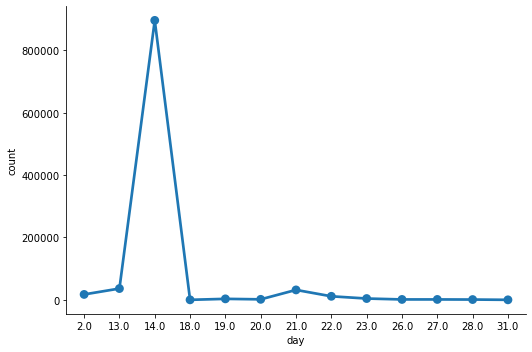

In [51]:
c = sns.catplot(x='day', y='count',
                data=daily_df,
                kind='point', height=5,
                aspect=1.5)

# 6. Hourly - Request reponse network traffic 

In [52]:
# Count of calls per hour

from pyspark.sql.functions import col, count, date_format, date_sub, date_trunc, month, next_day, to_timestamp, weekofyear, window, year

def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

hourly_df = (daily_traffic_df
                     .select(F.date_format('startTime','yyyy-MM-dd hh:mm:ss').alias('timestamp'))
                     .groupBy(window('timestamp', "15 minutes"))
                     .count())
# hourly_df= hourly_df.groupBy('startTime', window('startTime', "5 minutes")).sum("metric")

hourly_df = hourly_df.toPandas()
hourly_df

,window,count
0,"(2020-06-14 05:00:00, 2020-06-14 05:15:00)",144673
1,"(2020-06-14 05:15:00, 2020-06-14 05:30:00)",195734
2,"(2020-06-14 05:30:00, 2020-06-14 05:45:00)",37462
3,"(2020-06-14 06:30:00, 2020-06-14 06:45:00)",33552
4,"(2020-06-14 06:00:00, 2020-06-14 06:15:00)",41820
...,...,...
191,"(2022-05-31 06:15:00, 2022-05-31 06:30:00)",8
192,"(2022-05-31 06:30:00, 2022-05-31 06:45:00)",4
193,"(2022-05-31 08:30:00, 2022-05-31 08:45:00)",6
194,"(2022-05-31 08:45:00, 2022-05-31 09:00:00)",8


In [53]:
window_start = hourly_df['window'].map(lambda r : Row(start =r[0]))
window_start= spark.createDataFrame(window_start).toPandas()
hourly_df["start"]=window_start
hourly_df.drop(columns=["window"], inplace=True)
hourly_df

,count,start
0,144673,2020-06-14 05:00:00
1,195734,2020-06-14 05:15:00
2,37462,2020-06-14 05:30:00
3,33552,2020-06-14 06:30:00
4,41820,2020-06-14 06:00:00
...,...,...
191,8,2022-05-31 06:15:00
192,4,2022-05-31 06:30:00
193,6,2022-05-31 08:30:00
194,8,2022-05-31 08:45:00


<Figure size 432x360 with 0 Axes>

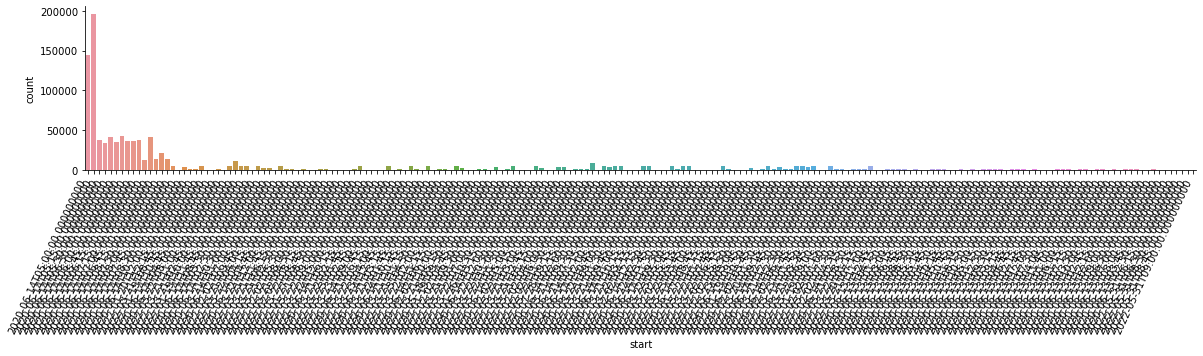

In [54]:
plt.figure(figsize=(6,5))
chart = sns.catplot(x='start', y='count',
                data=hourly_df,
                kind='bar', height=3, aspect=6)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

# 7. Energy consumption  and Carbon Footprint

In [61]:
from carbonfootprint.carbon import Carbon
from carbonfootprint.fuelmix import Fuelmix
# furlpercent_obj = carbonfp.power_utilities.Fuelmix("north_west")

In [72]:
column_list = ("Wind",    "Solar",  "Hydro",  "Other",    "Petroleum",  "Natural gas", "Coal",     "Nuclear",  "Battery", "Imports")
column_list_carbon = [ "carbon_"+sub + "(kgeCO2)" for sub in column_list]

## 7.1 Energy consumption 

In [80]:
hourly_df["energyConsumption(kWh)"] = hourly_df["count"]*0.4
hourly_df["power(W)"]= hourly_df["energyConsumption(kWh)"]/60
hourly_df.head()

,count,start,energyConsumption(kWh),power(W),Wind(W),Solar(W),Hydro(W),Other(W),Petroleum(W),Natural gas(W),...,carbon_Solar(kgeCO2),carbon_Hydro(kgeCO2),carbon_Other(kgeCO2),carbon_Petroleum(kgeCO2),carbon_Natural gas(kgeCO2),carbon_Coal(kgeCO2),carbon_Nuclear(kgeCO2),carbon_Battery(kgeCO2),carbon_Imports(kgeCO2),carbon_total(kgeCO2)
0,144673,2020-06-14 05:00:00,57869.2,964.486667,18.542885,0.384973,25.472406,47.929187,2.951463,660.486013,...,0.000018,0.000611,0.001150,0.001446,0.323638,0.051456,0.001752,0.0,0.0,0.380294
1,195734,2020-06-14 05:15:00,78293.6,1304.893333,29.522074,0.441947,26.870390,66.292082,8.043439,904.754329,...,0.000021,0.000645,0.001591,0.003941,0.443330,0.055882,0.002410,0.0,0.0,0.508174
2,37462,2020-06-14 05:30:00,14984.8,249.746667,11.652588,0.089087,4.614710,13.345242,1.603567,166.076099,...,0.000004,0.000111,0.000320,0.000786,0.081377,0.009716,0.000486,0.0,0.0,0.092940
3,33552,2020-06-14 06:30:00,13420.8,223.680000,8.774703,0.066601,3.446610,12.570969,1.515176,148.603841,...,0.000003,0.000083,0.000302,0.000742,0.072816,0.008888,0.000454,0.0,0.0,0.083394
4,41820,2020-06-14 06:00:00,16728.0,278.800000,17.253357,0.083856,4.297616,15.848771,1.886758,178.151921,...,0.000004,0.000103,0.000380,0.000925,0.087294,0.011191,0.000572,0.0,0.0,0.100676


In [81]:
region ="north_west"
furlpercent_obj = Fuelmix(region)
df_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(hourly_df)

    count               start  energyConsumption(kWh)     power(W)    Wind(W)  \
0  144673 2020-06-14 05:00:00                 57869.2   964.486667  18.542885   
1  195734 2020-06-14 05:15:00                 78293.6  1304.893333  29.522074   
2   37462 2020-06-14 05:30:00                 14984.8   249.746667  11.652588   
3   33552 2020-06-14 06:30:00                 13420.8   223.680000   8.774703   
4   41820 2020-06-14 06:00:00                 16728.0   278.800000  17.253357   

   Solar(W)   Hydro(W)   Other(W)  Petroleum(W)  Natural gas(W)  ...  \
0  0.384973  25.472406  47.929187      2.951463      660.486013  ...   
1  0.441947  26.870390  66.292082      8.043439      904.754329  ...   
2  0.089087   4.614710  13.345242      1.603567      166.076099  ...   
3  0.066601   3.446610  12.570969      1.515176      148.603841  ...   
4  0.083856   4.297616  15.848771      1.886758      178.151921  ...   

   carbon_Solar(kgeCO2)  carbon_Hydro(kgeCO2)  carbon_Other(kgeCO2)  \
0        

## 7.2 Carbon Emission 

In [82]:
carbonemissio_pbj = Carbon()
hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(df_hourly_fuelmix)
hourly_fuelmix_carbon.head()

,count,start,energyConsumption(kWh),power(W),Wind(W),Solar(W),Hydro(W),Other(W),Petroleum(W),Natural gas(W),...,carbon_Solar(kgeCO2),carbon_Hydro(kgeCO2),carbon_Other(kgeCO2),carbon_Petroleum(kgeCO2),carbon_Natural gas(kgeCO2),carbon_Coal(kgeCO2),carbon_Nuclear(kgeCO2),carbon_Battery(kgeCO2),carbon_Imports(kgeCO2),carbon_total(kgeCO2)
0,144673,2020-06-14 05:00:00,57869.2,964.486667,187.574312,-0.024395,228.045866,24.712287,1.463709,210.456963,...,-1.170967e-06,0.005473,0.000593,0.000717,0.103124,0.233047,0.000337,0.0,0.0,0.345541
1,195734,2020-06-14 05:15:00,78293.6,1304.893333,260.844055,-0.067306,300.184359,35.167338,2.019177,288.607743,...,-3.230684e-06,0.007204,0.000844,0.000989,0.141418,0.311083,0.000465,0.0,0.0,0.465131
2,37462,2020-06-14 05:30:00,14984.8,249.746667,47.907545,0.006591,56.613814,7.005877,0.388849,56.798353,...,3.163519e-07,0.001359,0.000168,0.000191,0.027831,0.060215,0.000091,0.0,0.0,0.090430
3,33552,2020-06-14 06:30:00,13420.8,223.680000,41.075446,0.000000,53.287226,6.239987,0.357592,51.415826,...,0.000000e+00,0.001279,0.000150,0.000175,0.025194,0.052854,0.000082,0.0,0.0,0.080227
4,41820,2020-06-14 06:00:00,16728.0,278.800000,48.812813,-0.007480,65.664678,7.801374,0.441305,65.432806,...,-3.590277e-07,0.001576,0.000187,0.000216,0.032062,0.067302,0.000103,0.0,0.0,0.102032


Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

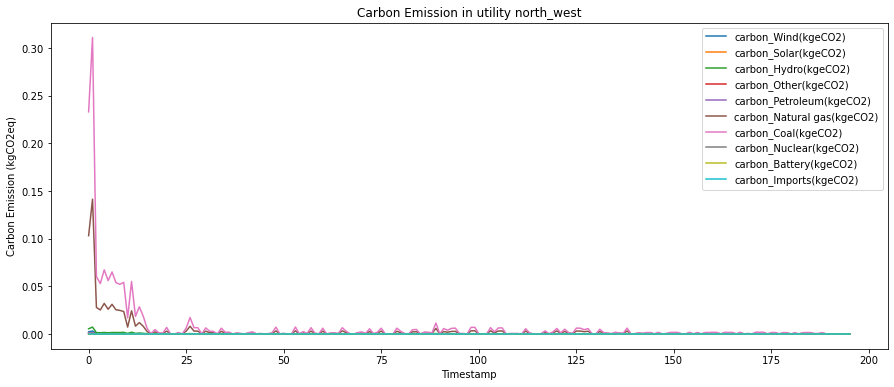

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
hourly_fuelmix_carbon.plot( 
    # x = "DateTime24",
    y = np.array(column_list_carbon),
    title = "Carbon Emission in utility "+ region ,
    ax=ax) 

ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")

## CAISO

    count               start  energyConsumption(kWh)     power(W)    Wind(W)  \
0  144673 2020-06-14 05:00:00                 57869.2   964.486667  18.542885   
1  195734 2020-06-14 05:15:00                 78293.6  1304.893333  29.522074   
2   37462 2020-06-14 05:30:00                 14984.8   249.746667  11.652588   
3   33552 2020-06-14 06:30:00                 13420.8   223.680000   8.774703   
4   41820 2020-06-14 06:00:00                 16728.0   278.800000  17.253357   

   Solar(W)   Hydro(W)   Other(W)  Petroleum(W)  Natural gas(W)  ...  \
0  0.384973  25.472406  47.929187      2.951463      660.486013  ...   
1  0.441947  26.870390  66.292082      8.043439      904.754329  ...   
2  0.089087   4.614710  13.345242      1.603567      166.076099  ...   
3  0.066601   3.446610  12.570969      1.515176      148.603841  ...   
4  0.083856   4.297616  15.848771      1.886758      178.151921  ...   

   carbon_Solar(kgeCO2)  carbon_Hydro(kgeCO2)  carbon_Other(kgeCO2)  \
0        

Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

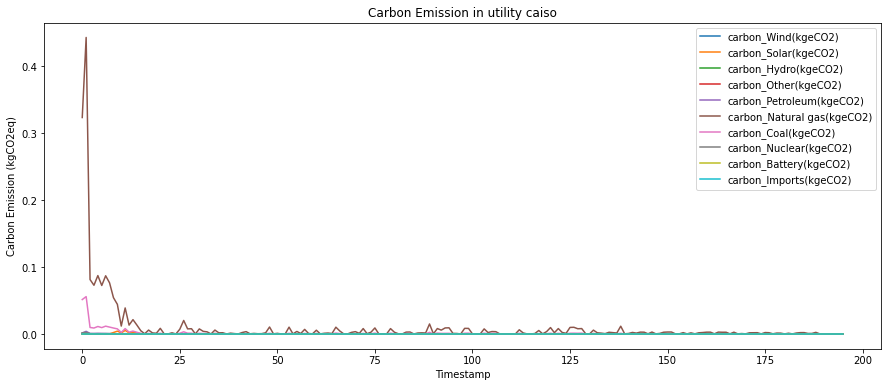

In [79]:
region ="caiso"
furlpercent_obj = Fuelmix(region)
df_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(hourly_df)

carbonemissio_pbj = Carbon()
hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(df_hourly_fuelmix)

fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
hourly_fuelmix_carbon.plot( 
    # x = "DateTime24",
    y = np.array(column_list_carbon),
    title = "Carbon Emission in utility "+ region ,
    ax=ax) 

ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")